# ADL Project - Pneumonia Detection with Chest X-Ray Images - Group B
Pneumonia is an infection that causes inflammation in one or both of the lungs and may be caused by a virus, bacteria, fungi or other germs. Physician may conduct a physical exam and use chest x-ray, chest CT, chest ultrasound, or needle biopsy of the lung to help diagnose your condition. However, with the scope of project is X-Ray Images.Typically, An X-Ray Image exam will allow Physician to check on lungs, heart, and blood vessels to help determine if one have pneumonia. When interpreting the X-Ray, the radiologist will look for white spots in the lungs (called infiltrates) that identify an infection. Such exams will also help determine if one have any complications related to pneumonia such as abscesses or pleural effusions (fluid surrounding the lungs).
This project aim to identify the infection of Pneumonia by deep learning methods, more specif- ically focusing on computer vision. To be noted, solutions for addressing Chest X-Ray Images from Kaggle were referenced and chatGPT was used to solve problems met and revise the code.

In [299]:
import os
import random
import pandas as pd
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch
import torchvision.models as models
from PIL import Image
from torch import nn
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout, Input
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Loading Data

In [300]:
directory_path = "/Users/lianhechu/Documents/Applied AI Master Program/D7047E Advanced Deep Learning/ADL Project/chest_xray"
entries = os.listdir(directory_path)
print(entries)

['.DS_Store', 'test', 'train', 'val']


In [301]:
train_dir = os.path.join(directory_path, 'train')
os.listdir(train_dir)

['.DS_Store', 'PNEUMONIA', 'NORMAL']

In [302]:
val_dir = os.path.join(directory_path, 'val')
os.listdir(train_dir)

['.DS_Store', 'PNEUMONIA', 'NORMAL']

In [303]:
test_dir = os.path.join(directory_path, 'test')
os.listdir(test_dir)

['.DS_Store', 'PNEUMONIA', 'NORMAL']

In [304]:
# display_images function will randomly display images from certain file path
def display_images(dir_path, num_images = 3):
    if not os.path.isdir(dir_path):
        print("Directory does not found!")
        return
    files = [os.path.join(dir_path,file) for file in os.listdir(dir_path) if file.lower().endswith(('jpg','jpeg'))]
    # find the images within a file
    if len(files) < num_images:
        print("Not enough images in the directory!")
        return
    selected_images = random.sample(files, num_images)
    fig, axes = plt.subplots(1, num_images, figsize = (12,3))
    for ax, image_file in zip(axes, selected_images):
        img = Image.open(image_file)
        print(img.size) # Aim to check wether images are in a same size.
        ax.imshow(img)
        ax.axis('on')
        ax.set_title(os.path.basename(image_file))
    plt.show()

(2144, 2028)
(1804, 1612)
(2010, 1747)


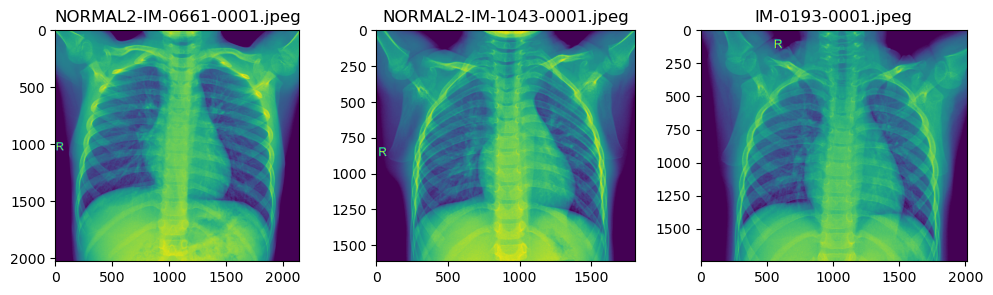

In [305]:
train_normal_dir = os.path.join(directory_path, 'train', 'NORMAL') # Find the path of NORMAL file within train dataset
display_images(train_normal_dir)

(1200, 808)
(928, 568)
(446, 232)


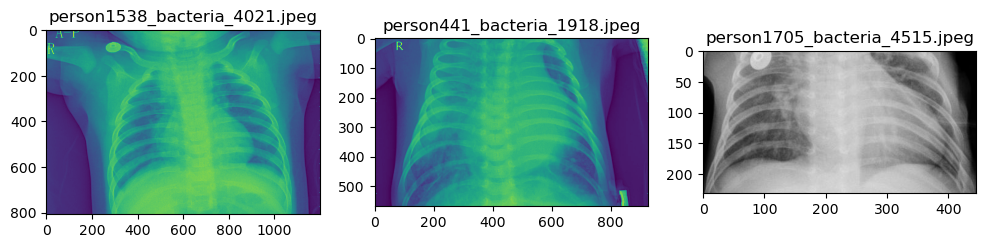

In [306]:
train_pneumonia_dir = os.path.join(directory_path, 'train', 'PNEUMONIA')
display_images(train_pneumonia_dir)

#  Train a CNN model to Classify Images

## Step1. Data Preprocessing and Augumentation

In [307]:
# function create_generators to create generators with provided data path: image sizes are normalized to 150 x 150.
def create_generators(data_dir, img_size = (150,150), batch_size = 16):
    # Set up image generators with normalization and augmentation for training datasets.
    # ImageDataGenerator rescale the images. 
    train_datagen = ImageDataGenerator(
        rescale = 1/255,
        rotation_range = 30,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest'
    )
    
    # Create data generators
    train_generator = train_datagen.flow_from_directory(
        directory = f'{data_dir}/train',
        target_size = img_size,
        batch_size = batch_size,
        class_mode = 'binary',
        shuffle = True
    )
    
    return train_generator

In [308]:
# Create generators for training datasets
train_generator = create_generators(directory_path)

Found 5216 images belonging to 2 classes.


## Step2. Set up CNN Model

In [309]:
# Difine a convolutional network with 5 convolutional layers, a flatten layer, Three fully connected layers in which
# the last layer as the output layer.
def CNN_model():
    model = Sequential([
        Input(shape = (150,150,3)),
        
        Conv2D(32, (2,2), padding = 'same', activation = 'relu'),
        # 32 filters with a kernel 2 x 2, 'same' padding means ouput has the same spatial dimension as the input
        # input is 150 x 150 RGB images.
        MaxPooling2D(2,2), # Reduces the spatial dimensions by 2 x 2 using max pooling, stride = 2.
        
        Conv2D(64, (2,2), padding = 'same', activation = 'relu'),
        MaxPooling2D(2,2),       
        
        Conv2D(128, (2,2), padding = 'same', activation = 'relu'),
        MaxPooling2D(2,2),       
        
        Conv2D(256, (2,2), padding = 'same', activation = 'relu'),
        MaxPooling2D(2,2),
        
        Conv2D(512, (2,2), padding = 'same', activation = 'relu'),
        MaxPooling2D(2,2),
        
        Flatten(), # Converts 3D feature maps to 1D feature vector
        
        Dense(256, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)),
        # l2 regularization to prevent overfitting by adding a penality on large weights
        Dropout(0.5), # Randomly drop 50% of neurons during training to prevent overfitting.
        
        Dense(64, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)),
        Dropout(0.5),
        
        Dense(1,activation = 'sigmoid') # 1 neuron with a sigmoid function, outputs a probability for binary classification
    ]) 
    
    return model

In [310]:
# Instantiate the model
model = CNN_model()

In [311]:
# Compile the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [312]:
# Print the model summary
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 150, 150, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 75, 75, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 37, 37, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 18, 18, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 9, 9, 512)      │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,811,617 (10.73 MB)

 Trainable params: 2,811,617 (10.73 MB)

 Non-trainable params: 0 (0.00 B)

## Step3. Train the Model and Evaluate with Validation Datasets

In [313]:
# Setup Validation Data Generator
validation_datagen = ImageDataGenerator(rescale = 1/255)
validation_generator = validation_datagen.flow_from_directory(
    directory = f'{directory_path}/val',
    target_size = (150,150),
    batch_size = 16,
    class_mode = 'binary',
)

Found 16 images belonging to 2 classes.


In [314]:
epochs = 15
# Train the model with training dataset and evaluate with validation dataset
history = model.fit(train_generator, epochs = epochs, verbose=1, validation_data = validation_generator)

Epoch 1/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - accuracy: 0.7231 - loss: 0.7487 - val_accuracy: 0.5000 - val_loss: 0.7569
Epoch 2/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.7394 - loss: 0.5107 - val_accuracy: 0.5625 - val_loss: 0.8208
Epoch 3/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.7717 - loss: 0.4833 - val_accuracy: 0.7500 - val_loss: 0.7751
Epoch 4/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.7883 - loss: 0.4719 - val_accuracy: 0.8125 - val_loss: 0.6629
Epoch 5/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.8014 - loss: 0.4348 - val_accuracy: 0.7500 - val_loss: 0.7062
Epoch 6/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.8003 - loss: 0.4161 - val_accuracy: 0.7500 - val_loss: 0.6063
Epoch 7/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.8605 - loss: 0.3555 - val_accuracy: 0.6875 - val_loss: 0.7215
Epoch 8/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.8717 - loss: 0.3390 - 

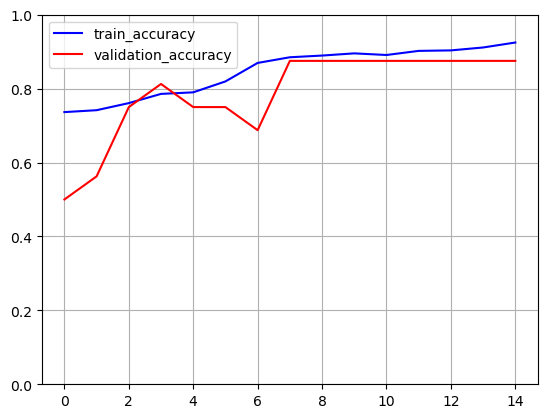

In [315]:
# Plot the training accuracy and validation accuracy
plt.plot(history.history['accuracy'], color = 'blue', label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], color = 'red', label = 'validation_accuracy')
plt.legend()
plt.grid()
plt.ylim(0,1.0)
plt.show()

## Step4. Test the Model

In [316]:
# Setup test generator
test_datagen = ImageDataGenerator(rescale = 1/255)
test_generator = test_datagen.flow_from_directory(
    directory = f'{directory_path}/test',
    target_size = (150,150),
    batch_size = 16,
    class_mode = 'binary',
    shuffle = False
)

Found 624 images belonging to 2 classes.


In [317]:
# Evaluate the model with test dataset
test_loss, test_accuracy = model.evaluate(test_generator, steps = test_generator.samples//test_generator.batch_size)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8454 - loss: 0.4182
Test accuracy: 82.05%


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
Confusion Matrix
[[195  39]
 [ 73 317]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.73      0.83      0.78       234
   PNEUMONIA       0.89      0.81      0.85       390

    accuracy                           0.82       624
   macro avg       0.81      0.82      0.81       624
weighted avg       0.83      0.82      0.82       624



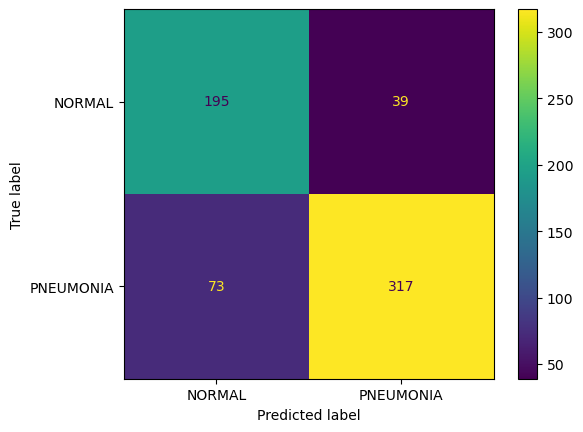

In [318]:
# Use trained model to make predictions on the test data
test_generator.reset() # Reset the generator to start from the beginning of the dataset.
predictions = model.predict(test_generator, steps = len(test_generator), verbose = 1)
# steps: batches of samples to draw from the generator before stopping
# verbose = 1 : display a progess bar showing the prediction process

predicted_classes = np.where(predictions > 0.5, 1, 0)
#If predicted probability is greater than 0.5, classify as class '1' or positive for PNEUMONIA.
true_classes = test_generator.classes 
# Retrieve true class labels from test generator. The result is a numpy array of true labels for the test samples.
# [0,0,1....]
class_labels = list(test_generator.class_indices.keys()) 
# Retrieve class labels from the generator. The result is a list of class names: ['NORMAL'.....]

cm = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix')
print(cm)

report = classification_report(true_classes, predicted_classes, target_names = class_labels)
print('Classification Report')
print(report)

ConfusionMatrixDisplay(confusion_matrix = cm,  display_labels=class_labels).plot()

## Step5. Predict Random Images

In [319]:
# Function to load images from a file, preprocess them to match input requirements of a CNN, return a numpy array.
def load_preprocess_image(img_path, target_size=(150,150)):
    img = Image.open(img_path) # Load an image.
    if img.mode != 'RGB':
        img = img.convert('RGB') # Convert an image to RGB.
    img = img.resize(target_size) # Resize an image to the target size.
    img_array = image.img_to_array(img) # Convert the image to a numpy array.
    img_array = np.expand_dims(img_array,axis=0) 
    # Expand dimensions of the array: add an extra dimension to be (1, 150, 150, 3), 1 is batch size.
    img_array /= 255.0 # Normalize the pixel to [0,1]
    return img_array

In [320]:
# Function to predict classes of randomly selected pages.
def predict_random_images(dir_path, num_images = 3):
    files = [os.path.join(dir_path,file) for file in os.listdir(dir_path) if file.lower().endswith(('jpg','jpeg'))]
    # List all image file in the directory.
    
    selected_images = random.sample(files, num_images)
    
    image_names = [os.path.basename(image_file) for image_file in selected_images]
    # Extract base names of selected images.
    print(image_names)
    
    fig, axes = plt.subplots(1, num_images, figsize = (12,3))
    for ax, image_file in zip(axes, selected_images):
        img = Image.open(image_file) # Load the image.
        preprocessed_img = load_preprocess_image(image_file) # Preprocess the image.
        prediction = model.predict(preprocessed_img) # Make a prediction using the trained model.
        prediction_class = 'PNEUMONIA' if prediction > 0.5 else 'NORMAL'
        
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"File: {os.path.basename(image_file)}\n predicted:{prediction_class}")
                     
    plt.show()
    return selected_images, image_names

['NORMAL2-IM-1106-0001.jpeg', 'IM-0499-0001-0001.jpeg', 'NORMAL2-IM-1132-0001.jpeg']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


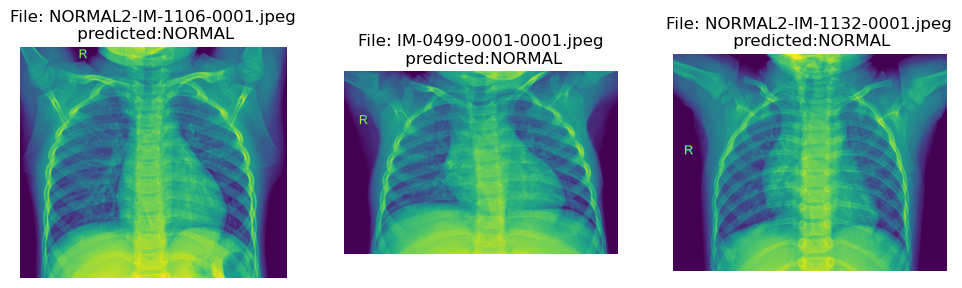

In [321]:
selected_images, image_names = predict_random_images(train_normal_dir) 
# Predict NORMAL images from training dataset.

['person100_bacteria_481.jpeg', 'person83_bacteria_409.jpeg', 'person117_bacteria_556.jpeg']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


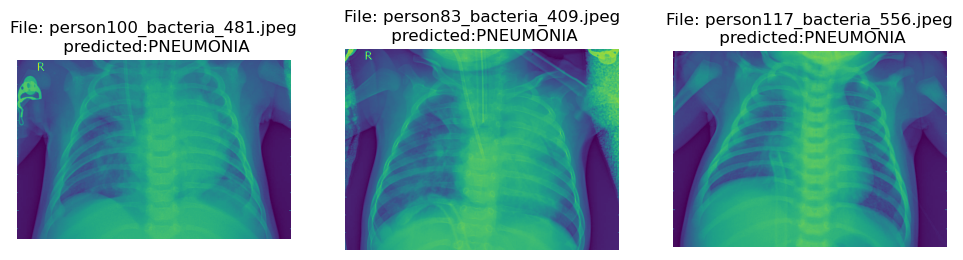

In [322]:
test_pneumonia_dir = os.path.join(directory_path, 'test', 'PNEUMONIA')
selected_images, image_names = predict_random_images(test_pneumonia_dir) 
# Predict PNEUMONIA images from test dataset.

#  Classify Images through Transferring Learning

## Step1 Data Processing and Augmentation

In [323]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32

In [324]:
# Data preprocessing for all three dataset and only training dataset was performed augumentation.
data_transforms = {
    'train':transforms.Compose([
        transforms.Resize((227,227)),
        transforms.RandomHorizontalFlip(), # Randomly flip image horizontally with a probability of 0.5.
        transforms.RandomRotation(20), # Randomly rotate images 20 degree in either direction.
        transforms.RandomResizedCrop(227, scale = (0.8, 1.0)),
        # Randomly crops the image to 227 X 227 after being resized, with scaling factor 0.8 to 1.0.
        transforms.ColorJitter(brightness = 0.3, contrast = 0.3, saturation = 0.3, hue = 0.3),
        # Randomly change the brightness, contrast, saturation and hue of images.
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229,0.224,0.225])
        # Normalize tesnsor image with mean and sd for each channel R,G,B. ([mean_red, mean_green, mean_blue],
        # [sd_red, sd_green, sd_blue]). Values were calculated from ImageNet dataset.
    ]), 
    'val':transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229,0.224,0.225])
    ]),
    'test':transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229,0.224,0.225])
    ]),
    
}

In [325]:
# Load datasets
img_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, transform=data_transforms['val']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

In [326]:
dataloaders = {
    'train': DataLoader(img_datasets['train'], batch_size = batch_size, shuffle=True, num_workers = 3),
    'val': DataLoader(img_datasets['val'], batch_size = batch_size, shuffle=False, num_workers = 3),
    'test': DataLoader(img_datasets['test'], batch_size = batch_size, shuffle=False, num_workers = 3)
}

In [327]:
dataset_sizes = {x: len(img_datasets[x]) for x in ['train', 'val', 'test']}
class_names = img_datasets['train'].classes
print("Classes", class_names)
print("Dataset sizes", dataset_sizes)

Classes ['NORMAL', 'PNEUMONIA']
Dataset sizes {'train': 5216, 'val': 16, 'test': 624}


In [328]:
tf_model = models.alexnet(pretrained = True) # Load AlexNet model trainded on ImageNet dataset (1.2 million images
# accross 1000 classes, pretrained = True means weights have been trained).

for param in tf_model.features.parameters():
    param.requires_grad = True # Unfreeze layers in the feature extractor. Weights of theses layers will be updated.

# Modify the classifier
num_features = tf_model.classifier[6].in_features
# Retrieve number of input features to the last fully connected layer (layer 6) of AlexNet classifier.
tf_model.classifier[6] = nn.Linear(num_features, 2)
# Replace the last fully connected layer with a nn.Linear layer that has 2 output features, corresponding to binary
# classification. 

tf_model = tf_model.to(device)

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Step 2 Train the Model

In [329]:
# Function to train a model.
def train_model(model, criterion, optimizer, dataloaders, dataset_size, num_epochs):
    start = time.time() # Record the starting time.
    best_accuracy = 0.0 # Store best validation accuracy achieved.
    best_model_weights = copy.deepcopy(model.state_dict())
    # Store model weights corresponding to the best validation accuracy.
    
    for epoch in range(num_epochs):
        print('-' * 30)
        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            else: 
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for (inputs, labels) in dataloaders[phase]:
                labels = labels.to(device)   
                inputs = inputs.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    _, predicted = torch.max(outputs, 1)
                    # torch.max returns two values: max_values along the dimension, and max_indices of the max_values.
                    # max_values here is highest probabilities predicted by the model for each input.
                    # max_indices here is calss labels corresponding to the highest scores.
                    # - means ignore the max_values returned. predicted is the predicted class labels.
                    
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward() 
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predicted == labels.data)
                
            avg_running_loss = running_loss / (dataset_sizes[phase])
            avg_accuracy = running_corrects / (dataset_sizes[phase])
            
            print(f"Epoch [{epoch+1}/{num_epochs}] - {phase} Loss: {avg_running_loss:.4f} - Accuracy{100*avg_accuracy:.4f}%")
            
            if phase == 'val' and avg_accuracy > best_accuracy:
                best_accuracy = avg_accuracy
                best_model_weights = copy.deepcopy(model.state_dict())
                
        if scheduler:
            scheduler.step() # Steps the scheduler to adjust the learning rate based on the epoch. Such as Reduce 
            # learning rate by a factor every epoch or every few epochs...
        print()
                
    time_elapsed = time.time() - start
    print(" Training completed")
    print(f'Best validation accuracy: {100*best_accuracy:4f}%')
    
    model.load_state_dict(best_model_weights)
    return model

In [330]:
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(tf_model.classifier.parameters(), lr=0.001, weight_decay = 1e-5)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 6, gamma = 0.1)
# Learning rate scheduling which can reduce the learning rate when a metric such as accuracy has stopped improving.

num_epochs = 5

trained_model = train_model(tf_model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs)

------------------------------
Epoch [1/5] - train Loss: 0.3574 - Accuracy89.6089%
Epoch [1/5] - val Loss: 1.0746 - Accuracy62.5000%

------------------------------
Epoch [2/5] - train Loss: 0.1594 - Accuracy93.9801%
Epoch [2/5] - val Loss: 0.2633 - Accuracy93.7500%

------------------------------
Epoch [3/5] - train Loss: 0.1516 - Accuracy94.1718%
Epoch [3/5] - val Loss: 0.3098 - Accuracy87.5000%

------------------------------
Epoch [4/5] - train Loss: 0.1383 - Accuracy95.0537%
Epoch [4/5] - val Loss: 0.3496 - Accuracy81.2500%

------------------------------
Epoch [5/5] - train Loss: 0.1621 - Accuracy94.4402%
Epoch [5/5] - val Loss: 0.1493 - Accuracy100.0000%

 Training completed
Best validation accuracy: 100.000000%


## Step3. Test the Model

In [333]:
# Funtion to evaluate the performance of a trained model on a dataset.
def test(model, criterion, dataloaders, dataset):
    model.eval()
    test_loss = 0 # Accumulates the loss.
    correct = 0 # Count the number of correct predictions.

    y_pred = [] # Store the predicted class labels of all samples.
    y_true = [] # Sore the true class labels of all samples.

    with torch.no_grad(): # Disable gradient calculation to reduce memory and speed up.
        for (inputs, labels) in dataloaders[dataset]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            
            y_true.extend(labels.cpu().numpy()) 
            # Append true labels to y_true after moving them to cpu and convert to numpy.

            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1) 
            y_pred.extend(predicted.cpu().numpy())
            
            correct += (predicted == labels).sum().item()
    
    test_loss /= len(dataloaders[dataset])
    test_accuracy = correct /len(dataloaders[dataset].dataset)
    
    print(f"{dataset.capitalize()}set Accuracy: {100*test_accuracy:>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(confusion_matrix = cm,  display_labels=class_names).plot()

Testset Accuracy: 90.9%, Avg loss: 0.260966 



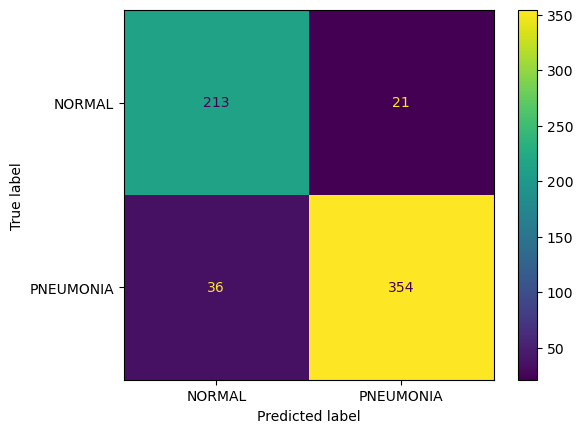

In [332]:
# Test with trained model and result visualization.
test(trained_model, criterion, dataloaders, 'test')